In [1]:
import matplotlib.pyplot as plt  
import numpy as np
from sklearn import datasets,decomposition,manifold
import sklearn.neighbors as nb
import scipy.io as sio
import struct
import math
import pylab
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
#%pylab inline

In [2]:
def loadPGM(name):
    original_data_file = open(name,"rb")
    data_buff = original_data_file.read()
    data_index = 0
    s = struct.unpack_from('>14c',data_buff, data_index)
    data_index += struct.calcsize('>14c')
    m = struct.unpack_from('>10304B',data_buff, data_index)
    m = np.mat(m)
    return m

def PCM_show():
    data = loadPGM("orl_faces/s1/1.pgm")
    data = data.reshape(112, 92)
    fig = plt.figure()
    plotwindow = fig.add_subplot(111)
    plt.imshow(data, cmap='gray')
    plt.show()



In [3]:
data=sio.loadmat("faces/ORL_32x32.mat")
face = data['fea']
label = data['gnd']

In [4]:
def LPP(data, k, d, t):
    '''
    data is the original data. m*n(m=samples, n=dimensions)
    '''
    
    
    data = np.matrix(data)
    N = data.shape[0]
    D = data.shape[1]
    
    # step 1
    # find the nearest neighbors (k). Here we get the distance from (x-y)^2
    # distance N*N
   
    data_tmp = np.sum(np.multiply(data, data), axis=1)
    distance=np.mat(data_tmp + data_tmp.T - 2*data*data.T)
    sort_index = np.argsort(distance,axis=1)
    # k nearest neibors
    neibors = sort_index[:,1:k+1]
    
    # step 2
    # weights
    
    W=np.zeros([N,N])
    D=np.zeros([N,N])
    for i in range(N):
        for j in neibors[i].A[0]:
            W[i, j] = math.exp(-distance[i, j]/t)
            D[i, i] +=W[i, j]  
            
    
    # Step 3
    # mappings 
    
    L=D-W
    X = np.dot(np.dot(data.T, D), data)
    X = np.dot(X.I,np.dot(np.dot(data.T, L), data))
    eigenValues, eigenVectors=np.linalg.eig(X)
    eigenValuesIndex = np.argsort(eigenValues)
    mapping = np.mat(eigenVectors[:, eigenValuesIndex[0:d]])
    
    return mapping.T

/home/huangzhenyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


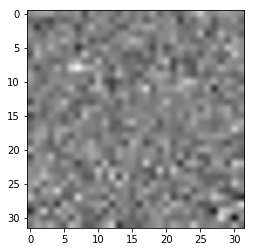

In [ ]:
def LPP_faces1():
    matfn = 'faces/3Train/2.mat'
    index = sio.loadmat(matfn)
    testIdx = index['testIdx'] -1    
    trainIdx = index['trainIdx'] -1  
    trainface = face[trainIdx]
    mapping = LPP(trainface/255, 10, 8, 10)
    tmp=mapping[2]
    tmp=tmp.reshape(32, 32).astype(float)
    pylab.imshow(tmp.T, cmap='gray', interpolation='hamming')
    pylab.show()
    
LPP_faces1()

In [ ]:
def LPP_faces2():
    ## 112 * 92 ORL_faces
    allface=np.zeros((400, 10304))
    for i in range(40):
        for j in range(10):
            allface[i*10+j]=loadPGM("orl_faces/s"+str(i+1)+"/"+str(j+1)+".pgm")

    mapping = LPP(allface/255, 10, 8, 10)
    tmp=mapping[0]
    tmp=tmp.reshape(112, 92).astype(float)
    pylab.imshow(tmp, cmap='gray', interpolation='hamming')
    pylab.show()
LPP_faces2()

In [ ]:
def knn_score(train_data, train_label, test_data, test_label):
    knn = nb.KNeighborsClassifier(n_neighbors = 1)  
    knn.fit(train_data, train_label)
    s = knn.score(test_data, test_label)
    return s

In [ ]:
def LPPscore(l):
    ## 32 * 32 ORL_faces 
    s=0.0
    for i in range(50):
        matfn = 'faces/'+str(l)+'Train/'+str(i+1)+'.mat'
        index = sio.loadmat(matfn)
        testIdx = index['testIdx'] -1  
        trainIdx = index['trainIdx'] -1
        trainface = face[trainIdx]
        trainlabel = label[trainIdx].reshape(l*40,1)
        trainface = np.squeeze(trainface) 
        
        testface = face[testIdx]
        testlabel = label[testIdx].reshape(400-l*40,1)
        testface = np.squeeze(testface)  
       
        mapping = LPP(trainface/255, 10, 150, 10)
        traindata = np.dot(mapping, trainface.T)
        testdata = np.dot(mapping, testface.T)
        s+=knn_score(traindata.T, trainlabel, testdata.T, testlabel)
    return s/50

LPP_score = LPPscore(3)
print(LPP_score)

In [ ]:
def orl_scatters():
    # the first 100 samples
    face100 = np.squeeze(face)[:100]
    label100 = label.reshape(400)[:100]
    mapping = LPP(face100/255, 10, 2, 10)
    low_data = np.dot(mapping, face100.T).T
    
    fig = plt.figure(figsize=(10,7))
    plotwindow = fig.add_subplot(111)
    a = np.array(low_data)

    # draw the scatters
    color = ['green','dodgerblue','chartreuse','turquoise','orange','coral','salmon','darkgray','darkred','mediumpurple']
    for j in range(len(low_data)):
        plt.scatter(a[j][0], a[j][1],s=40, c=color[label100[j]-1])
    plt.show()
orl_scatters();

In [ ]:
def PCA(data,dimensions):
    '''
    data is the original data set，rows are samples of data,columns are the features
    '''

    # making data zero-means
    average = np.mean(data,0)
    data_zero = np.mat(data-average)
    
    #covariance
    covariance = np.cov(data_zero,rowvar=False)
    
    #eigenvalues
    eig_var,eig_vec = np.linalg.eig(covariance)
    
    
    #from the numpy doc, the eig_var may not be ordered.
    sort_eig = np.argsort(-eig_var)
    #return the index that make a sorted array

    #so we got the sorted eig_var
    sort_eig = sort_eig[:dimensions]
    principal_vec = np.mat(eig_vec[:,sort_eig])
    
    return principal_vec

def Laplacianfaces(data, k, d, t):
    
    data = np.matrix(data)
    N = data.shape[0]
    D = data.shape[1]
    
    # step 1
    # find the nearest neighbors (k). Here we get the distance from (x-y)^2
    # distance N*N
   
    data_tmp = np.sum(np.multiply(data, data), axis=1)
    distance=np.mat(data_tmp + data_tmp.T - 2*data*data.T)
    sort_index = np.argsort(distance,axis=1)
    # k nearest neibors
    neibors = sort_index[:,1:k+1]
    
    # step 2
    # weights
    
    W=np.zeros([N,N])
    D=np.zeros([N,N])
    for i in range(N):
        for j in neibors[i].A[0]:
            W[i, j] = math.exp(-distance[i, j]/t)
            D[i, i] +=W[i, j]  
            
    
    # Step 3
    # mappings 
    
    L=D-W
    X = np.dot(np.dot(data.T, D), data)
    X = np.dot(X.I,np.dot(np.dot(data.T, L), data))
    eigenValues, eigenVectors=np.linalg.eig(X)
    eigenValuesIndex = np.argsort(eigenValues)
    mapping = np.mat(eigenVectors[:, eigenValuesIndex[0:d]])
    
    mapping_PCA = PCA(data, d)
    
    return np.dot(mapping_PCA, mapping.T)


In [ ]:
def LPP_faces():
    matfn = 'faces/3Train/2.mat'
    index = sio.loadmat(matfn)
    testIdx = index['testIdx'] -1    
    trainIdx = index['trainIdx'] -1  
    trainface = face[trainIdx]
    mapping = Laplacianfaces(trainface/255, 40, 8, 10)
    tmp=mapping[2]
    tmp=tmp.reshape(32, 32).astype(float)
    pylab.imshow(tmp.T, cmap='gray', interpolation='hamming')
    pylab.show()
    
LPP_faces()